In [16]:
import import_ipynb
import numpy as np
import h5py
import torch
from angle_encoding import angle_encoding
from haar_noising import apply_haar_scrambling

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)


torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])  # Connect the last qubit to the first

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out
    
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x
    
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 1

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


Epoch [1/50], Loss: 1.0098
Epoch [2/50], Loss: 0.9414
Epoch [3/50], Loss: 0.8758
Epoch [4/50], Loss: 0.8128
Epoch [5/50], Loss: 0.7526
Epoch [6/50], Loss: 0.6952
Epoch [7/50], Loss: 0.6406
Epoch [8/50], Loss: 0.5889
Epoch [9/50], Loss: 0.5399
Epoch [10/50], Loss: 0.4937
Epoch [11/50], Loss: 0.4504
Epoch [12/50], Loss: 0.4098
Epoch [13/50], Loss: 0.3719
Epoch [14/50], Loss: 0.3367
Epoch [15/50], Loss: 0.3041
Epoch [16/50], Loss: 0.2741
Epoch [17/50], Loss: 0.2465
Epoch [18/50], Loss: 0.2212
Epoch [19/50], Loss: 0.1983
Epoch [20/50], Loss: 0.1775
Epoch [21/50], Loss: 0.1587
Epoch [22/50], Loss: 0.1419
Epoch [23/50], Loss: 0.1269
Epoch [24/50], Loss: 0.1135
Epoch [25/50], Loss: 0.1017
Epoch [26/50], Loss: 0.0912
Epoch [27/50], Loss: 0.0821
Epoch [28/50], Loss: 0.0741
Epoch [29/50], Loss: 0.0672
Epoch [30/50], Loss: 0.0612
Epoch [31/50], Loss: 0.0561
Epoch [32/50], Loss: 0.0517
Epoch [33/50], Loss: 0.0479
Epoch [34/50], Loss: 0.0447
Epoch [35/50], Loss: 0.0420
Epoch [36/50], Loss: 0.0397
E

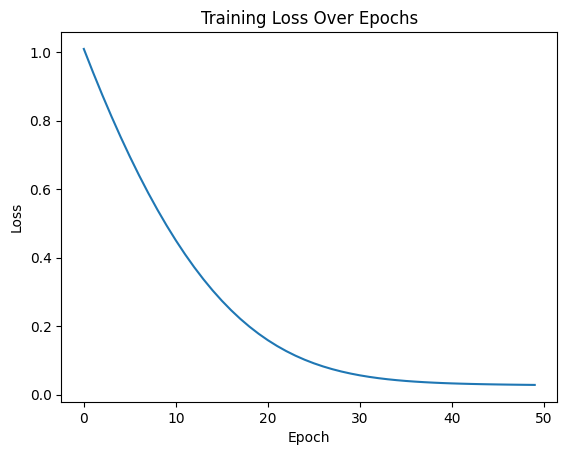

In [21]:
num_epochs = 50
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [ ]:
def generate_new_samples(model, num_samples, input_dim):
    random_input = torch.randn(num_samples, input_dim)
    
    model.eval()
    
    with torch.no_grad():
        generated_output = model(random_input)
    
    generated_images = generated_output.view(num_samples, 8, 8, 4).cpu().numpy()
    
    return generated_images

num_samples_to_generate = 5

generated_images = generate_new_samples(model, num_samples_to_generate, input_dim)
print(generated_images)

def visualize_generated_images(images):
    for i in range(images.shape[0]):
        for channel in range(4):
            plt.figure(figsize=(5, 5))
            plt.imshow(images[i, :, :, channel], cmap='viridis')
            plt.colorbar()
            plt.title(f'Sample {i+1}, Channel {channel+1}')
            plt.show()

visualize_generated_images(generated_images)

denoised_states = model(scrambled_states.view(num_samples, -1))
denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
visualize_encoded_data(denoised_states, sample_index=10)


In [ ]:
print(denoised_states.shape)
print(data_X.shape)

# Decode [num_samples, 8, 8, 4] into 1 channel [num_samples, 16, 16]
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

decoded_data = decode(denoised_states)
decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_data(data_X, decoded_data, sample_index=0)